In [10]:
import pandas as pd
import numpy as np
import os


In [11]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_ori.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_ori.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_ori.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_ori.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_ori.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_ori.pkl")

### Segment into Windows

In [12]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

def create_windows(X, y, window_size=100, step_size=50):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [13]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

### Encode Label

In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Implementation of "Deep ConvLSTM with self-attention for human activity decoding using wearable sensors." by Satya P. Singh et al. (IEEE Sensors, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/DeepConvLSTM.py

# X_train_windows.shape == (n_samples, 100, 9)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # ⇒ (100, 6)
num_classes = len(set(y_train_windows_encoded))                    

model_deep_convlstm = Sequential([
    # ——— Conv feature extractor ———
    Conv1D(64, kernel_size=5, activation='relu', padding='valid',
           input_shape=input_shape),
    Conv1D(64, kernel_size=5, activation='relu', padding='valid'),
    Conv1D(64, kernel_size=5, activation='relu', padding='valid'),
    Conv1D(64, kernel_size=5, activation='relu', padding='valid'),

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(128, return_sequences=True),
    # second LSTM returns only the last output
    LSTM(128, return_sequences=False),

    # ——— classification head ———
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_deep_convlstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_deep_convlstm.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 96, 64)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 92, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 88, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 84, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 84, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,040 (1.13 MB)

 Trainable params: 297,040 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model_deep_convlstm.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 222s 125ms/step - accuracy: 0.6698 - loss: 1.0736 - val_accuracy: 0.7964 - val_loss: 0.6267
Epoch 2/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 210s 121ms/step - accuracy: 0.8455 - loss: 0.4816 - val_accuracy: 0.8036 - val_loss: 0.5673
Epoch 3/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 214s 123ms/step - accuracy: 0.8426 - loss: 0.4876 - val_accuracy: 0.8084 - val_loss: 0.5665
Epoch 4/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 212s 122ms/step - accuracy: 0.8918 - loss: 0.3409 - val_accuracy: 0.8021 - val_loss: 0.6323
Epoch 5/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 212s 122ms/step - accuracy: 0.8965 - loss: 0.3206 - val_accuracy: 0.8479 - val_loss: 0.4435
Epoch 6/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 212s 122ms/step - accuracy: 0.9015 - loss: 0.3042 - val_accuracy: 0.8135 - val_loss: 0.5508
Epoch 7/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 214s 123ms/step - accuracy: 0.9105 - loss: 0.2765 - val_accuracy: 0.8224 - val_loss: 0.5515
Epoch 8/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 215s 123ms/step - ac

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.5937
Test Accuracy: 0.8372
560/560 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step


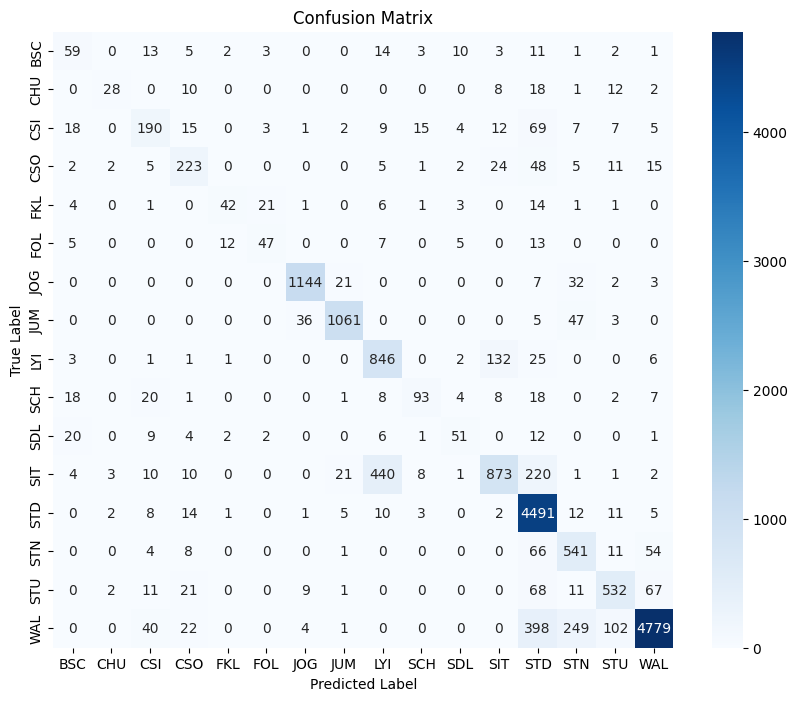

Classification Report:
               precision    recall  f1-score   support

         BSC       0.44      0.46      0.45       127
         CHU       0.76      0.35      0.48        79
         CSI       0.61      0.53      0.57       357
         CSO       0.67      0.65      0.66       343
         FKL       0.70      0.44      0.54        95
         FOL       0.62      0.53      0.57        89
         JOG       0.96      0.95      0.95      1209
         JUM       0.95      0.92      0.94      1152
         LYI       0.63      0.83      0.71      1017
         SCH       0.74      0.52      0.61       180
         SDL       0.62      0.47      0.54       108
         SIT       0.82      0.55      0.66      1594
         STD       0.82      0.98      0.89      4565
         STN       0.60      0.79      0.68       685
         STU       0.76      0.74      0.75       722
         WAL       0.97      0.85      0.91      5595

    accuracy                           0.84     17917
  

In [19]:
label_classes = le.classes_.tolist()

metrics = evaluate_model(model_deep_convlstm, X_test_windows, y_test_windows_encoded, label_classes=label_classes)


### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # --- CNN Blocks ---
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

    # --- LSTM Layer ---
    # return_sequences=True is important to preserve the temporal structure for the attention layer.
    x = LSTM(64, return_sequences=True)(x)

    # --- Self-Attention ---
    # The Attention layer computes a weighted sum of the LSTM outputs.
    # Using the same tensor for queries and keys/values implements self-attention.
    attn_output = Attention()([x, x])
    # Optionally, you can combine the attention output with the LSTM output.
    # Here, we simply use the attention output further.
    x = GlobalAveragePooling1D()(attn_output)

    # --- Dense Layers for Classification ---
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
